# Zillow House Tax Values

## Imports

In [1]:
# import data manipulation tools
import numpy as np
import pandas as pd
# import functions to reproduce and show our results
import wrangle as w
import explore as e
import modeling as m

## Acquire

* Data was acquired from the Codeup database
* The data was initially 52320 rows and 11 columns
* Each row represents one house that had a transaction in 2017
* Each column represents one aspect of the house

In [2]:
# acquire data and first cleaning
train, validate, test = w.wrangle_zillow()

opening data from local file


## Prepare

* We removed outlier rows from the area, bathrooms or bedrooms columns.
* We filled in null values in the garage_sqft and cars_garage columns with 0
* We imputed the most common region based on the fips value
* We converted the data types to integer for all the columns except number of bathrooms
* After cleaning there were 45,517 rows of data

The dataset contains the variable 'fips', which translates to:
- 6037 - Los Angeles County, California
- 6059 - Orange County, California
- 6111 - Ventura County, California

In [3]:
# Scaling data and imputing missing values
train_scaled, validate_scaled, test_scaled = w.impute_and_scale(train, validate, test)

## Explore

* Does tax value correlate to the square footage of the house?
* Does tax value correlate to the property's lot size?
* Does tax value correlate to the number of cars that fit in the garage?
* Does the number of cars that fit in the garage correlate to the size of the garage?

## Question - Does the square footage of the house have a linear correlation witih tax value?

## Hypothesis
Is there a linear corellation between the square footage (area) of the house and the tax value?
- H$_0$: There is no correlation between area and tax value
- H$_a$: There is a linear correlation between area and tax value
- alpha: 0.05
- This will be a pearsonsr test

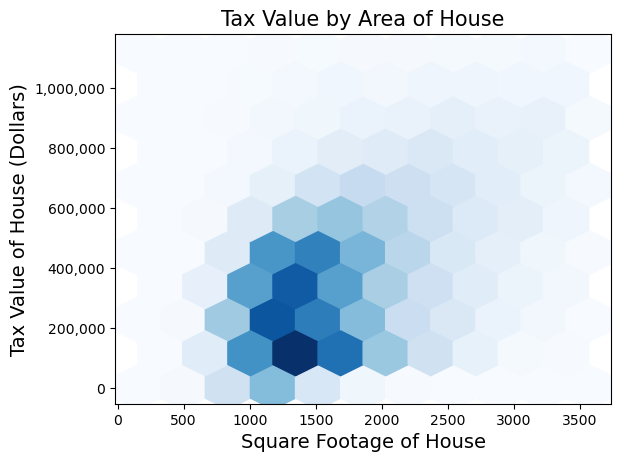

In [4]:
# get a visualization of house sqft by tax value
e.get_area_value(train)

In [5]:
# run a statistical test to check for a linear correlatioin between
# house sqft and tax value
e.get_pearson_area(train)

there is sufficient evidence to reject our null hypothesis
the p-value is 0.0
the r coeficient is 0.45028158739912466


#### There is enough evidence to show that there is a linear relationship between the square footage (area) of the house and the tax value (r coeficient of 0.45).

## Question - Does the garage square footage have a correlation to the amount of cars that can fit within it?

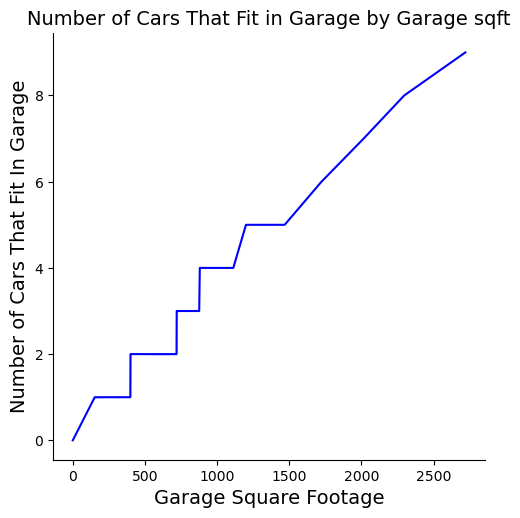

In [6]:
# get a visualiztion of cars_garage by garage_sqft
e.get_cars_by_sqft(train)

#### Garage square footage appears to have a very strong correlation to the number of cars that fit within the garage. (r coeficient of 0.98) So we will probably only want to use one of these variables in our modeling.

## Question - Does the number of cars that fit in the garage have a correlation to the tax value of the house?

# Hypothesis
cars_garage has a linear correlation to tax_value
- H$_0$: There is no linear correlation between cars_garage and tax_value
- H$_a$: There is a linear correlation between cars_garage and tax_value
- Confidence interval / alpha: 95% / 0.05
- This will be a pearsonsr correlation test

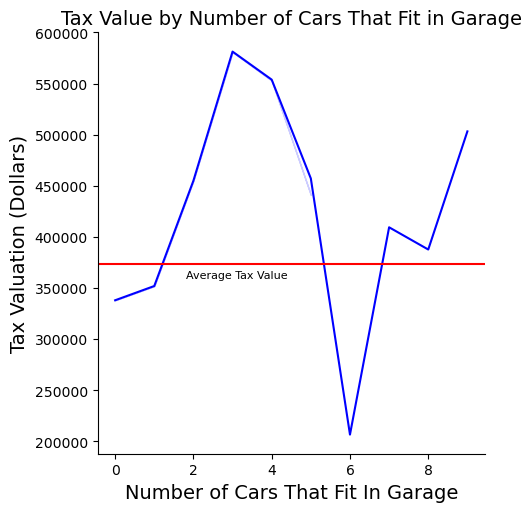

In [7]:
# get a visualization of cars_garage by tax value
e.get_cars_value(train)

In [8]:
# run a statistical test to check for a linear correlation between
# cars_garage and tax_value
e.get_pearson_garage(train)

there is sufficient evidence to reject our null hypothesis
the p-value is 0.0
the r coeficient is 0.24177353734407273


#### There is enough evidence to show that there is a linear correlation between the number of cars that fit in the property's garage and the tax value (r coeficient of 0.24)

## Question - Does property lot size have a correlation with the tax value of the house?

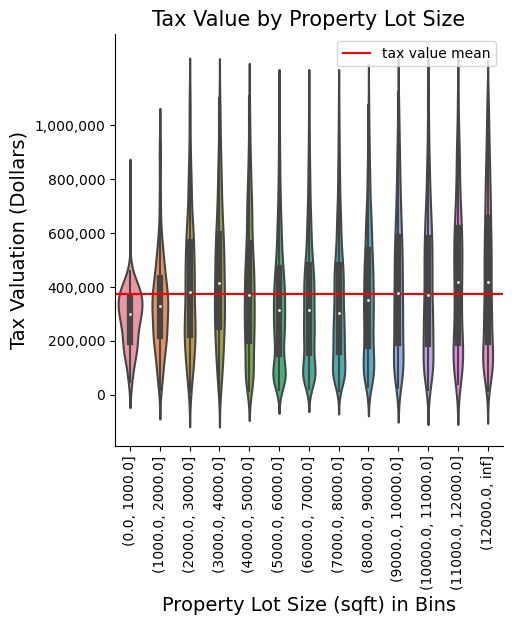

In [9]:
# get a visualization of property lot size by tax value
e.get_lot_bin_vis(train)

#### It seems that the tax_value is pretty evenly disbursed across every lot_size bin, so probably not a good estimator of tax_value (r coeficient of -0.0061)

## Exploration Summary
* We found that:
* Square footage of the house has the strongest correlation to the property's tax value
* Square footage of the garage has a very strong correlation to the number of cars that fit in the garage 
* Number of cars that fit in the garage has a moderate correlation to the property tax value
* Square footage of the property's lot has a very weak correlation to the tax value

### Features selected for modeling:
We will be using these features for modeling:
- 'pools', 'year_built', 'area', 'garage_sqft', 'region'

## Modeling

### Introduction
* Since we are looking at a linear regression problem we will be looking at the RMSE and R$^2$ metrics.
* RMSE evaluates the amount of error from the actual values present in the model
* R$^2$ is a measure of the amount of variance from the mean value explained by our model

In [10]:
# setup datasets for modeling
drops = ['tax_value','lot_size_binned']
X_train_scaled = train_scaled.drop(columns=drops)
y_train = pd.DataFrame(train_scaled.tax_value)
X_validate_scaled = validate_scaled.drop(columns=drops)
y_validate = pd.DataFrame(validate_scaled.tax_value)
X_test_scaled = test_scaled.drop(columns=drops)
y_test = pd.DataFrame(test_scaled.tax_value)
# list the chosen features to use
f_features = ['pools', 'year_built', 'area', 'garage_sqft', 'region']

In [11]:
# get metrics on our baseline (mean) model
m.get_baseline_model(y_train)

Baseline Model (mean)
RMSE for baseline model: 243722.13
R^2 for baseline model: 0.0


## Lasso + Lars Model

In [12]:
# get metrics on our lasso + lars model
lars = m.get_lars_model(X_train_scaled, y_train, 
                   X_validate_scaled, y_validate, f_features)

Lasso + Lars Model
RMSE on training data: 215268.7
RMSE on validation data: 219013.26
Difference in RMSE: 3744.5551
R^2 value: 0.2082


## Generalized Linear Model

In [13]:
# get metrics on our tweedie regression model
glm = m.get_tweedie_model(X_train_scaled, y_train, 
                      X_validate_scaled, y_validate, f_features)

Tweedie Model
RMSE on training data: 243722.13
RMSE on validation data: 246130.97
Difference in RMSE: 2408.842
R^2 value: 1.11e-16


## Polynomial Regression Model

In [14]:
# get metrics on our polynomial regression model
lm2, X_test_degree2 = m.get_polynomial_model(X_train_scaled, y_train, 
                         X_validate_scaled, y_validate,
                         X_test_scaled, f_features)

Polynomial Model
RMSE on training data: 210452.03
RMSE on validation data: 213462.82
Difference in RMSE: 3010.7873
R^2 value: 0.2478


### Test Model
* We will be using the Polynomial Regression Model for the test data
* The Polynomial Regression Model had the highest R$^2$ value while also having a low RMSE and low variation between train and validate datasets

In [15]:
# get metrics on our polynomial model using the test data
y_test = m.get_polynomial_test(lm2, X_test_degree2, y_test)

Polynomial Model on Test Data
RMSE on test data: 213160.52
R^2 value: 0.244


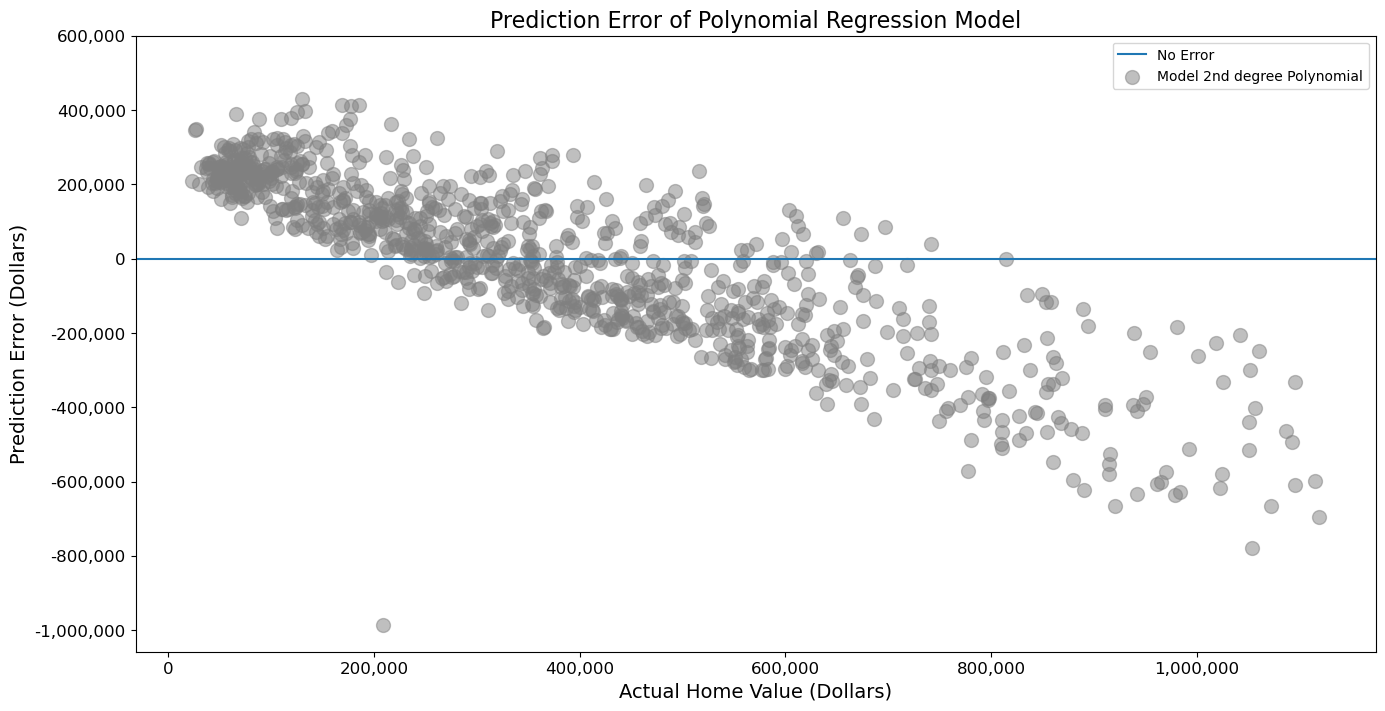

In [17]:
# get a plot of the prediction error in the test dataset to the actual values
m.get_pred_error_plot(y_test.sample(1000))

### Modeling Wrap 
* Our Polynomial Regression model was able to reduce the error from the baseline prediction model by \\$30,561 per property, with a total reduction in error for all houses that had a transaction in 2017 by \\$1,391,072,837 (1.39 billion dollars).

## Conclusion

### Summary
* The square footage of the house was the strongest driver of tax value of the property
* There were not many features that had strong correlations with the tax value, which made our model suffer

### Recommendations
* We recommend focusing on improving data quality, many of the fields in the dataset had incomplete or nonsensical values. (only 652 out of 11,077 pools in the dataset had sqft info)
* We also recommend adding a field to indicate if there are multiple structures on a property

### Next Steps
* If given more time, we would like to look at more multivariable combinations in order to see if we can find some stronger correlations to tax value